# Image Classification using Keras Code Example

https://keras.io/examples/vision/3D_image_classification/

import packages

In [3]:
import os
import zipfile
import numpy as np
import tensorflow as tf

import keras
from keras import layers

Download COVID-19 Chest CT Dataset

In [5]:
# Download URL of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = keras.utils.get_file(origin=url, cache_dir=os.getcwd(), cache_subdir='', extract=False)

# Download URL of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename_23 = keras.utils.get_file(origin=url, cache_dir=os.getcwd(), cache_subdir='', extract=False)

# Make a directory to store the data.
os.makedirs("MosMedData", exist_ok=True)

# Unzip data in the newly created directory.
with zipfile.ZipFile(filename, "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile(filename_23, "r") as z_fp:
    z_fp.extractall("./MosMedData/")

Rescale data:
- Rotate images so fixed orientation
- Scale HU between 1 and 0
- Resize width, height and depth

In [6]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

Read the data in zip files

In [7]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]

# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


## Build Training and Validation Datasets

Read and process scans

In [8]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

Binary classification of scans
1 = viral pneumonia
0 = normal

In [9]:
# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

print(abnormal_labels[:10])

[1 1 1 1 1 1 1 1 1 1]


Split the data 70-30 % Training - Validation

In [10]:
# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)

print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


## Data Augmentation

Add dimension to apply 3D convolutions

In [11]:
import random

from scipy import ndimage


def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


Apply data augmentation

In [12]:
# Define data loaders.
# Creates data and label pairs
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train)) #shuffles data order
    .map(train_preprocessing) #applies data augmentation
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)


visualise augmented CT data

Dimension of the CT scan is: (128, 128, 64, 1)


2025-02-11 17:12:30.463221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


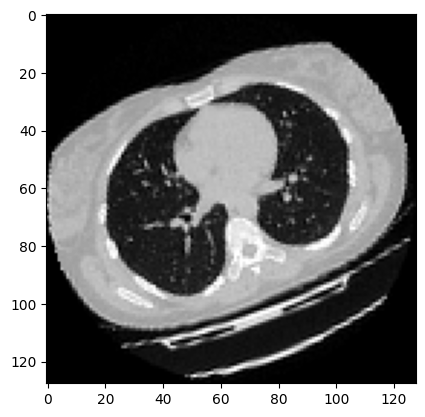

In [13]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")


visualise montage of slices

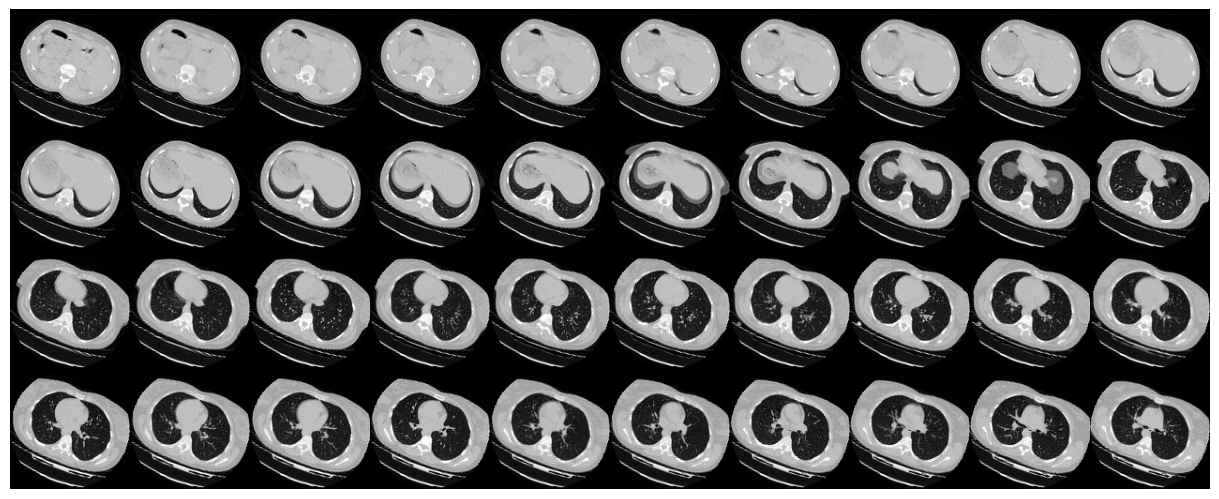

In [14]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

## Define 3D Convolutional Neural Network

In [4]:
import os
import tensorflow as tf
import numpy as np
import keras
from keras import layers

# Force CPU only for now
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.config.set_visible_devices([], 'GPU')

# Clear any existing models
keras.backend.clear_session()

def get_model(width=128, height=128, depth=64):
    """Build the 3D CNN model."""
    # Configure inputs for 3D data
    inputs = layers.Input((width, height, depth, 1))
    
    # Start with smaller number of filters
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # Gradually increase filters
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="3dcnn")

print("Creating model...")
model = get_model(width=128, height=128, depth=64)

print("Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("Model summary:")
model.summary()

Creating model...
Compiling model...
Model summary:


Model: "3dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 126, 126, 62,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 63, 63, 31, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 31, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 61, 61, 29, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 30, 30, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 14, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 28, 28, 12,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 14, 14, 6, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 6, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 12, 12, 4, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 6, 6, 2, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 2, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,296,577 (4.95 MB)

 Trainable params: 1,295,617 (4.94 MB)

 Non-trainable params: 960 (3.75 KB)

In [2]:
import tensorflow as tf
import keras
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.16.2
Keras version: 3.6.0


In [5]:
import os
import tensorflow as tf
import numpy as np
import keras
from keras import layers

# Clear any existing models
keras.backend.clear_session()

# Configure TensorFlow for Metal
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        try:
            tf.config.experimental.set_memory_growth(device, True)
            print(f"Memory growth enabled for {device}")
        except Exception as e:
            print(f"Error configuring {device}: {e}")

def get_model(width=128, height=128, depth=64):
    """Build the 3D CNN model."""
    inputs = layers.Input((width, height, depth, 1))
    
    # Full-scale model now that we know it builds
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="3dcnn")

print("Creating model...")
model = get_model(width=128, height=128, depth=64)

print("Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("Model summary:")
model.summary()

Error configuring PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): Physical devices cannot be modified after being initialized
Creating model...
Compiling model...
Model summary:


Model: "3dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 126, 126, 62,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 63, 63, 31, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 31, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 61, 61, 29, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 30, 30, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 14, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 28, 28, 12,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 14, 14, 6, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 6, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 12, 12, 4, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 6, 6, 2, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 2, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
import os
import tensorflow as tf
import numpy as np
import keras
from keras import layers

# Clear any existing models
keras.backend.clear_session()

# Configure TensorFlow for Metal
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        try:
            tf.config.experimental.set_memory_growth(device, True)
            print(f"Memory growth enabled for {device}")
        except Exception as e:
            print(f"Error configuring {device}: {e}")

def get_model(width=128, height=128, depth=64):
    """Build the 3D CNN model."""
    inputs = layers.Input((width, height, depth, 1))
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="3dcnn")

# Create model
print("Creating model...")
model = get_model(width=128, height=128, depth=64)

# Compile model
print("Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Create small test dataset
print("\nCreating test data...")
test_x = np.random.random((2, 128, 128, 64, 1)).astype(np.float32)
test_y = np.random.randint(0, 2, (2, 1)).astype(np.float32)

# Test single prediction first
print("\nTesting single prediction...")
_ = model.predict(test_x[0:1], verbose=1)
print("Prediction successful!")

# Test training with minimal batch
print("\nTesting training (1 epoch, batch size=1)...")
history = model.fit(
    test_x, 
    test_y,
    batch_size=1,
    epochs=1,
    verbose=1
)
print("Training test completed!")

Error configuring PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): Physical devices cannot be modified after being initialized
Creating model...
Compiling model...

Creating test data...

Testing single prediction...


In [2]:
import tensorflow as tf
import keras

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.15.0
Keras version: 2.15.0
GPU devices: []


In [5]:
import tensorflow as tf
import platform

print(f"Python version: {platform.python_version()}")
print(f"TensorFlow version: {tf.__version__}")
print("Available devices:", tf.config.list_physical_devices())
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# Try to run a simple operation on GPU
try:
    with tf.device('/GPU:0'):
        a = tf.random.normal([1000, 1000])
        b = tf.random.normal([1000, 1000])
        c = tf.matmul(a, b)
        print("\nGPU computation successful!")
except Exception as e:
    print("\nGPU computation failed:", str(e))

Python version: 3.10.16
TensorFlow version: 2.15.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU devices: []

GPU computation successful!


In [6]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['METAL_DEVICE_WRAPPER_TYPE'] = '0'

import tensorflow as tf
import platform

# Configure logger to show more info
import logging
tf.get_logger().setLevel(logging.INFO)

print(f"Python version: {platform.python_version()}")
print(f"TensorFlow version: {tf.__version__}")
print("\nInitial device list:")
print("Available devices:", tf.config.list_physical_devices())

# Try to initialize Metal
print("\nTrying to initialize Metal...")
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    print("Found physical devices:", physical_devices)
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Memory growth enabled")
except Exception as e:
    print("Error configuring GPU:", str(e))

# Test computation
print("\nTesting computation...")
try:
    with tf.device('/GPU:0'):
        a = tf.random.normal([1000, 1000])
        b = tf.random.normal([1000, 1000])
        c = tf.matmul(a, b)
        print("GPU computation successful!")
except Exception as e:
    print("GPU computation failed:", str(e))

Python version: 3.10.16
TensorFlow version: 2.15.0

Initial device list:
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Trying to initialize Metal...
Found physical devices: []

Testing computation...
GPU computation successful!
